In [1]:
%load_ext autoreload
%autoreload 2

# RNN for genetic circuits

Following https://docs.kidger.site/equinox/examples/train_rnn/

# Imports

In [15]:
import math

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import equinox as eqx
jax.config.update('jax_platform_name', 'cpu')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Load data

In [16]:

# fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
# data = pd.read_csv(fn)
# data.drop(columns=['Unnamed: 0'], inplace=True)

In [17]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size


def get_data(dataset_size, *, key):
    t = jnp.linspace(0, 2 * math.pi, 16)
    offset = jrandom.uniform(key, (dataset_size, 1), minval=0, maxval=2 * math.pi)
    x1 = jnp.sin(t + offset) / (1 + t)
    x2 = jnp.cos(t + offset) / (1 + t)
    y = jnp.ones((dataset_size, 1))

    half_dataset_size = dataset_size // 2
    x1 = x1.at[:half_dataset_size].multiply(-1)
    y = y.at[:half_dataset_size].set(0)
    x = jnp.stack([x1, x2], axis=-1)

    return x, y

In [18]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array

    def __init__(self, in_size, out_size, hidden_size, *, key):
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            return self.cell(inp, carry), None

        out, _ = lax.scan(f, hidden, input)
        # sigmoid because we're performing binary classification
        return jax.nn.sigmoid(self.linear(out) + self.bias)

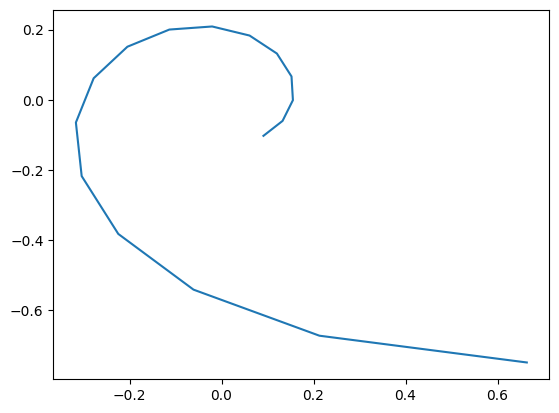

In [33]:
i = -1
plt.plot(xs[i, :, 0], xs[i, :, 1])

# Train

In [8]:
# def main(
#     dataset_size=10000,
#     batch_size=32,
#     learning_rate=3e-3,
#     steps=200,
#     hidden_size=16,
#     depth=1,
#     seed=5678,
# ):

dataset_size = 10000
batch_size = 32
learning_rate = 3e-3
steps = 200
hidden_size = 16
depth = 1
seed = 5678

data_key, model_key = jrandom.split(jrandom.PRNGKey(seed), 2)
xs, ys = get_data(dataset_size, key=data_key)
iter_data = dataloader((xs, ys), batch_size)

model = RNN(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key)


@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    # Trains with respect to binary cross-entropy
    return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

# Important for efficiency whenever you use JAX: wrap everything into a single JIT


@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


optim = optax.adam(learning_rate)
opt_state = optim.init(model)
for step, (x, y) in zip(range(steps), iter_data):
    loss, model, opt_state = make_step(model, x, y, opt_state)
    loss = loss.item()
    print(f"step={step}, loss={loss}")

pred_ys = jax.vmap(model)(xs)
num_correct = jnp.sum((pred_ys > 0.5) == ys)
final_accuracy = (num_correct / dataset_size).item()
print(f"final_accuracy={final_accuracy}")

step=0, loss=0.6857491731643677
step=1, loss=0.7045875787734985
step=2, loss=0.6954666376113892
step=3, loss=0.7010214328765869
step=4, loss=0.6992630362510681
step=5, loss=0.671714186668396
step=6, loss=0.7018579840660095
step=7, loss=0.6892243027687073
step=8, loss=0.6927156448364258
step=9, loss=0.6873202323913574
step=10, loss=0.6993614435195923
step=11, loss=0.7119702100753784
step=12, loss=0.682276725769043
step=13, loss=0.6847034692764282
step=14, loss=0.6975702047348022
step=15, loss=0.689339280128479
step=16, loss=0.6938771605491638
step=17, loss=0.6868393421173096
step=18, loss=0.6848992705345154
step=19, loss=0.6885260343551636
step=20, loss=0.6926348209381104
step=21, loss=0.6903123259544373
step=22, loss=0.6948642730712891
step=23, loss=0.6945183277130127
step=24, loss=0.701359748840332
step=25, loss=0.6856626272201538
step=26, loss=0.6886028051376343
step=27, loss=0.6994736194610596
step=28, loss=0.688610315322876
step=29, loss=0.7032516002655029
step=30, loss=0.692950367

In [9]:
jax.vmap(model)(xs[:2])

Array([[0.00473726],
       [0.00457697]], dtype=float32)